<a href="https://colab.research.google.com/github/rushilm2/AE-370-Group-Project1/blob/main/AE370_Proj1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using RK4 to observe the trajectories in a 3 Body system

## System Parameters

We begin by defining parameters for our system, consisting of a space probe, star, and gas giant. We treat our probe as massless as compared to the rest of our elements in the system and write everything in the order of astronomical units (AU) which are equivalent to $9.296 \cdot 10^6$ miles

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Constants and masses
G = 39.47841760435743   # Gravitational constant in AU^3 / (solar_mass * yr^2)
M_star = 0.3            # Star mass in solar masses
M_gas_giant = 0.05      # Gas giant mass in solar masses

R = 0.7  # Radius of the giant's circular orbit around the star (AU)
# We include the star + planet mass for the giant's orbital velocity
M_for_orbit = M_star + M_gas_giant

# Orbital angular velocity (radians/yr) for the gas giant
omega = np.sqrt(G * M_for_orbit / R**3)

R_star = 0.144 * (0.00465) #Radius of Star in AU (0.144 SR to AU)
R_giant = 0.0005 #Radius of Gas Giant in AU

# Gas giant position (analytic, circular orbit)
def position_gas_giant(t):
    """Return the (x, y) position of the gas giant at time t."""
    xg = R * np.cos(omega * t)
    yg = R * np.sin(omega * t)
    return np.array([xg, yg])


## Initial Conditions

We next need to define our initial conditions which are the initial radius and velocity of the probe. These conditions are critical to modeling system's behavior so for a stable system we want to set the intial conditions that are conducive for that system.

In [19]:
# Probe initial conditions
# Initial Conditions set for a stable system
r_probe_0 = np.array([1.0, 0.0])  # in AU
v_probe_0 = np.array([0, 1])  # in AU/yr, fairly high tangential velocity


## Probe Acceleration Fucntion

The gravity of the celestial bodies  will impose an accceleration onto our  massless probe of the form: $$a = \frac{-GM_1(r_1 - r_2)}{|(r_1-r_2)|^3}$$ In this cell we return the sum of the imposed accelerations from both the star and gas giant.

In [20]:
# Acceleration on the probe due to star + gas giant

def acceleration_probe(r_probe, t):
    """Compute acceleration on the probe from star (at origin) and gas giant."""
    # Vector from star to probe
    r_star_to_probe = r_probe  # star is at (0,0)
    dist_star = np.linalg.norm(r_star_to_probe)

    # Vector from giant to probe
    r_giant = position_gas_giant(t)
    r_giant_to_probe = r_probe - r_giant
    dist_giant = np.linalg.norm(r_giant_to_probe)

    # Gravitational accelerations
    a_star = -G * M_star * r_star_to_probe / dist_star**3
    a_giant = -G * M_gas_giant * r_giant_to_probe / dist_giant**3

    return a_star + a_giant

## RK4 Stepping Function

To numerically approximate the probes orbit over the course of a simulation period we use RK4 and implement it in the following cell. This uses the acceleration of the probe at each time step to determine the radius and velocity of the probe at the next time step.

In [21]:
# RK4 integrator for the probe

def rk4_step(r, v, t, dt):
    """Advance the probe state (r,v) by dt using RK4."""

    # k1
    a1 = acceleration_probe(r, t)
    k1r = v
    k1v = a1

    # k2
    a2 = acceleration_probe(r + 0.5*dt*k1r, t + 0.5*dt)
    k2r = v + 0.5*dt*k1v
    k2v = a2

    # k3
    a3 = acceleration_probe(r + 0.5*dt*k2r, t + 0.5*dt)
    k3r = v + 0.5*dt*k2v
    k3v = a3

    # k4
    a4 = acceleration_probe(r + dt*k3r, t + dt)
    k4r = v + dt*k3v
    k4v = a4

    # Combine
    r_next = r + (dt/6.0)*(k1r + 2*k2r + 2*k3r + k4r)
    v_next = v + (dt/6.0)*(k1v + 2*k2v + 2*k3v + k4v)

    return r_next, v_next

## Orbit Simulation and Plotting

Now that the system parameters, intitial condtions, and stepping function are all defined, we can begin simulating the 3 body problem. The following cell models the orbit of the space probe in the system containing a star and gas giant. We model the probe to satisfy the following design constraints:
- The spacecraft shall not impact either the gas giant or the star.
- The spacecraft shall not be ejected from the system for a 20-year span.
- The spacecraft shall stay within a 1.5 AU radius of the star at all times.
- The spacecraft shall not be captured by the gas giant and orbit around it.

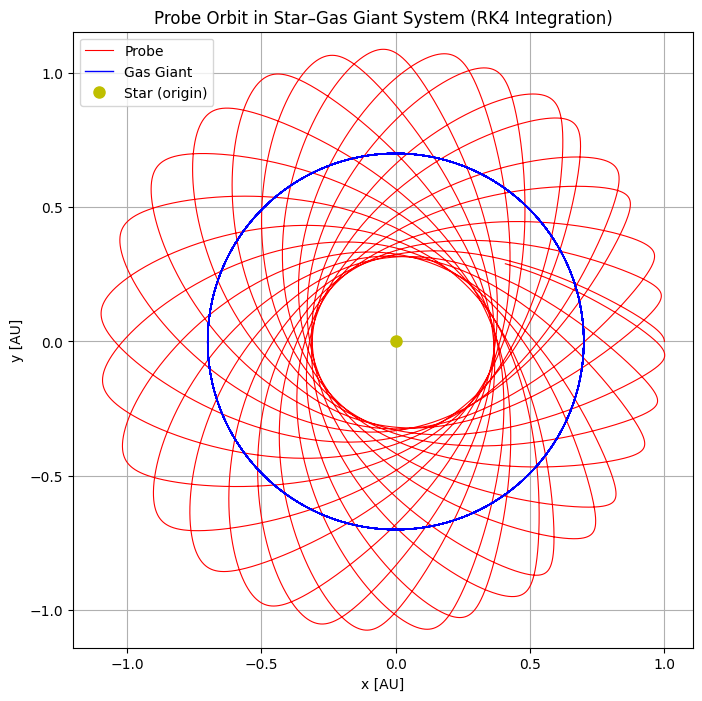

In [22]:
# Main simulation

t0 = 0.0
tf = 20.0   # total time in years
dt = 0.001
N = int((tf - t0)/dt)

# Storage arrays
probe_positions = np.zeros((N, 2))
giant_positions = np.zeros((N, 2))
times = np.linspace(t0, tf, N)

# Initialize
r_probe = r_probe_0.copy()
v_probe = v_probe_0.copy()

for i, t in enumerate(times):
    probe_positions[i] = r_probe
    giant_positions[i] = position_gas_giant(t)
    dist_to_star = np.linalg.norm(r_probe)
    dist_to_giant = np.linalg.norm(r_probe - position_gas_giant(t))

    if dist_to_star < R_star:
      print(f"The probe collided into the Star at time {t:.2f} years.")
      break
    if dist_to_star > 1.5:
      print(f"The probe was ejected from the orbit at time {t:.2f} years.")
      break
    if dist_to_giant < R_giant:
      print(f"The probe collided into the Gas Giant at time {t:.2f} years.")
      break

    # Advance the probe by one RK4 step
    r_probe, v_probe = rk4_step(r_probe, v_probe, t, dt)

# Plotting

plt.figure(figsize=(8,8))
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.plot(probe_positions[:,0], probe_positions[:,1], 'r-', lw=0.8, label='Probe')
plt.plot(giant_positions[:,0], giant_positions[:,1], 'b-', lw=1.0, label='Gas Giant')
plt.plot(0, 0, 'yo', label='Star (origin)', markersize=8)
plt.xlabel('x [AU]')
plt.ylabel('y [AU]')
plt.title('Probe Orbit in Star–Gas Giant System (RK4 Integration)')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


# Alternative Initial Conditions

Now that we know what the trajectory of the spaceprobe looks like at a stable specified initial probe radius and velocity, we can explore the results of our system at varying starting conditions. We can ask the following questions:
- Which initial conditions yield to the probe getting captured by the gas giant?
- At which intiial conditions do the probe collide with the Gas giant?
- Does the probe ever collide with the Star?
- How often does the probe get ejected from the system?

However, we still want to ensure that the design constraints are maintained so we set the intial radius and velocities to lie within the range (0.1, 1.5) and explore how our probe behaves over the course of the 20 year period at each intial condition.

In [ ]:
successes = []
eject = []
star_impact = []
gas_impact = []
giant_capture = []
r_vals = np.arange(0.1, 1.5, 0.1)  # AU
v_vals = np.arange(0.1, 1.5, 0.1)  # AU/yr

for r0 in r_vals:
    for v0 in v_vals:
        # Set up probe initial conditions
        r_probe = np.array([r0, 0.0])
        v_probe = np.array([0.0, v0])

        # Initialize logs and flags
        r_probe_list = []
        failed = False

        for t in np.arange(0, 20, dt):  # 20-year sim

            r_probe_list.append(r_probe)

            dist_to_star = np.linalg.norm(r_probe)
            dist_to_giant = np.linalg.norm(r_probe - position_gas_giant(t))

            # Failure checks
            if dist_to_star < R_star:
                failed = "Star Impact"
                star_impact.append((r0,v0))
                break
            if dist_to_star > 1.5:
                failed = "Ejection"
                eject.append((r0,v0))
                break
            if dist_to_giant < R_giant:
                failed = "Gas Giant Collision"
                gas_impact.append((r0,v0))
                break

            r_probe, v_probe = rk4_step(r_probe, v_probe, t, dt)

        # Final probe trajectory to check for capture
        if not failed:
            r_probe_array = np.array(r_probe_list)
            dist_to_giant_over_time = np.linalg.norm(r_probe_array - position_gas_giant(0), axis=1)
            close_passes = np.sum(dist_to_giant_over_time < 0.05)
            if close_passes > 100:  # Arbitrary: too many close orbits
                giant_capture.append((r0, v0))
                failed = "Captured by Giant"

        if not failed:
            successes.append((r0, v0))
        else:
            print(f"Fail: r0={r0:.2f}, v0={v0:.2f} — {failed}")

Fail: r0=0.10, v0=0.10 — Ejection
Fail: r0=0.10, v0=0.20 — Ejection
Fail: r0=0.10, v0=0.30 — Ejection
Fail: r0=0.10, v0=0.40 — Ejection
Fail: r0=0.10, v0=0.50 — Ejection
Fail: r0=0.10, v0=0.60 — Ejection
Fail: r0=0.10, v0=0.70 — Ejection
Fail: r0=0.10, v0=0.80 — Ejection
Fail: r0=0.10, v0=0.90 — Ejection
Fail: r0=0.10, v0=1.00 — Ejection
Fail: r0=0.10, v0=1.10 — Ejection
Fail: r0=0.10, v0=1.20 — Ejection
Fail: r0=0.10, v0=1.30 — Ejection
Fail: r0=0.10, v0=1.40 — Ejection
Fail: r0=0.20, v0=0.10 — Ejection
Fail: r0=0.20, v0=0.20 — Ejection
Fail: r0=0.20, v0=0.30 — Ejection
Fail: r0=0.20, v0=0.40 — Ejection
Fail: r0=0.20, v0=0.50 — Ejection
Fail: r0=0.20, v0=0.60 — Ejection
Fail: r0=0.20, v0=0.70 — Ejection
Fail: r0=0.20, v0=0.80 — Ejection
Fail: r0=0.20, v0=0.90 — Ejection
Fail: r0=0.20, v0=1.00 — Ejection
Fail: r0=0.20, v0=1.10 — Ejection
Fail: r0=0.20, v0=1.20 — Ejection
Fail: r0=0.20, v0=1.30 — Ejection
Fail: r0=0.20, v0=1.40 — Ejection
Fail: r0=0.30, v0=0.10 — Ejection
Fail: r0=0.30,

## Plotting Various Initial Conditions

After testing every combination of intiial conditions between 0.1 and 1.5 for initial probe position and velocity in increments of 0.1, we can now plot the results.

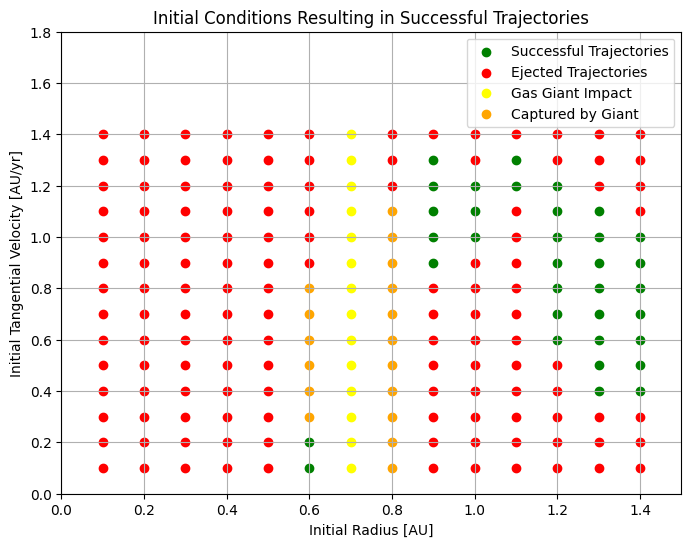

In [ ]:
import matplotlib.pyplot as plt

rs, vs = zip(*successes)
re, ve = zip(*eject)
#rs_star, vs_star = zip(*star_impact) #Happens 0 times
rs_giant, vs_giant = zip(*gas_impact)
rs_capture, vs_capture = zip(*giant_capture)
plt.figure(figsize=(8,6))
plt.xlim(0., 1.5)
plt.ylim(0, 1.8)
plt.scatter(rs, vs, color='green', label='Successful Trajectories')
plt.scatter(re, ve, color='red', label='Ejected Trajectories')
plt.scatter(rs_giant, vs_giant, color='yellow', label='Gas Giant Impact')
plt.scatter(rs_capture, vs_capture, color='orange', label='Captured by Giant')
plt.xlabel('Initial Radius [AU]')
plt.ylabel('Initial Tangential Velocity [AU/yr]')
plt.title('Initial Conditions Resulting in Successful Trajectories')
plt.grid(True)
plt.legend()
plt.show()


# Error Computation

Although we have implemented the Runge Kutta 4th order method, we do not know if it has been correctly implemented until we validate our method using an error convergence test.

## Convergence and Error Analysis

We test for convergence by running our simulation at different time step sizes ($\Delta t$) and observe how the error behaves. We will then compute the error between the numerical approximation and the approximation at a set time step size.

The error at a given time can be defined as:

$$ \text{Error} = ||r_{approx} - r_{ref}|| $$

The convergence order is expected to be $ O(\Delta t^4) $ for the RK4 method. We will plot the error for different values of $\Delta t$ to verify this.

dt = 0.01000, error = 7.87062e-02
dt = 0.00500, error = 2.34348e-03
dt = 0.00250, error = 7.17334e-05
dt = 0.00125, error = 2.13618e-06
Observed convergence order between dt=0.01000 and dt=0.00500: 5.070
Observed convergence order between dt=0.00500 and dt=0.00250: 5.030
Observed convergence order between dt=0.00250 and dt=0.00125: 5.070
Time step dt = 0.00250 yields error below tolerance of 1.0e-03 AU.


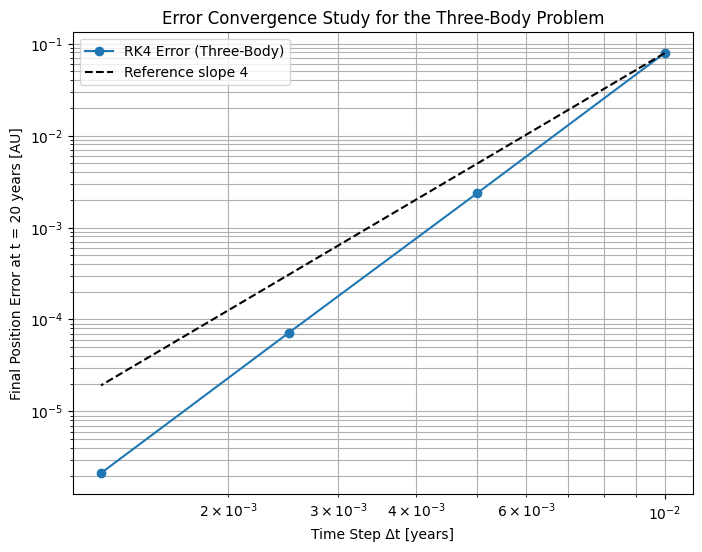

In [24]:
# Simulation function for the probe in the three-body system

def simulate_probe(dt, t0, tf, r_probe_0, v_probe_0):
    """
    Run the three-body probe simulation from t0 to tf using time step dt.
    Returns the final probe position.
    """
    N = int((tf - t0) / dt)
    t = t0

    for i in range(N):
        #Check if the probe crashes into the star
        if np.linalg.norm(r_probe_0) < R_star:
            # Break if a crash occurs (for simplicity in error calculation)
            break
        r_probe_0, v_probe_0 = rk4_step(r_probe_0, v_probe_0, t, dt)
        t += dt
    return r_probe_0

# Convergence study parameters

# Choose initial conditions that yield a quasi-regular (non-chaotic) orbit
r_probe_0 = np.array([1.0, 0.0])   # Initial position [AU]
v_probe_0 = np.array([0.0, 1])   # Initial velocity [AU/yr]

t0 = 0.0
tf = 20.0  # Total simulation time in years

# Compute a "reference" solution using a very small time step
dt_ref = 1e-4
r_ref = simulate_probe(dt_ref, t0, tf, r_probe_0, v_probe_0)

# Define a set of dt values for error convergence tests
dt_values = np.array([0.01, 0.005, 0.0025, 0.00125])
errors = []
orders = []  # observed order of convergence

# Simulate with each dt and compute the final error relative to the reference
for dt in dt_values:
    r_approx = simulate_probe(dt, t0, tf, r_probe_0, v_probe_0)
    error = np.linalg.norm(r_approx - r_ref)
    errors.append(error)
    print(f"dt = {dt:.5f}, error = {error:.5e}")

# Compute the observed order of convergence between subsequent dt values
for i in range(1, len(dt_values)):
    p = np.log(errors[i-1]/errors[i]) / np.log(dt_values[i-1]/dt_values[i])
    orders.append(p)
    print(f"Observed convergence order between dt={dt_values[i-1]:.5f} and dt={dt_values[i]:.5f}: {p:.3f}")

# Determine an appropriate time step based on a chosen error tolerance

tolerance = 1e-3  # set an error tolerance (in AU)
suitable_dt = None
for dt, err in zip(dt_values, errors):
    if err < tolerance:
        suitable_dt = dt
        break
if suitable_dt:
    print(f"Time step dt = {suitable_dt:.5f} yields error below tolerance of {tolerance:.1e} AU.")
else:
    print("None of the tested time steps met the desired error tolerance.")

# Plot the error convergence on a log-log scale

plt.figure(figsize=(8,6))
plt.loglog(dt_values, errors, 'o-', label='RK4 Error (Three-Body)')
# Plot a reference line with a slope of 4 (expected for RK4)
ref_line = dt_values**4 * errors[0] / dt_values[0]**4
plt.loglog(dt_values, ref_line, 'k--', label='Reference slope 4')
plt.xlabel("Time Step Δt [years]")
plt.ylabel("Final Position Error at t = 20 years [AU]")
plt.title("Error Convergence Study for the Three-Body Problem")
plt.grid(True, which='both')
plt.legend()
plt.show()
